In [90]:
import numpy as np
import pandas as pd
import json
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from typing import List

In [91]:
data_path = "../datasets/currency/price_dollar_rl.json"

In [92]:
def read_data(path: str) -> pd.DataFrame:
    with open(path, "r") as f:
        data = json.loads(f.read())
    data = data["data"]
    dataset = []
    data = data[::-1]  # reverse data
    le = len(data)
    for i in range(le - 1):
        dataset.append(
            [
                int(data[i][0].replace(",", "", data[i][0].count(","))),
                int(data[i][1].replace(",", "", data[i][1].count(","))),
                int(data[i][2].replace(",", "", data[i][2].count(","))),
                int(data[i][3].replace(",", "", data[i][3].count(","))),
                (
                    1
                    - int(data[i][3].replace(",", "", data[i][3].count(",")))
                    / int(data[i + 1][3].replace(",", "", data[i + 1][3].count(",")))
                )
                if i < le - 1
                else 0,
                (
                    1
                    - int(data[i][1].replace(",", "", data[i][2].count(",")))
                    / int(data[i][2].replace(",", "", data[i][2].count(",")))
                )
                if i > 0
                else 0,
                datetime.datetime.strptime(data[i][6], "%Y/%m/%d"),
            ]
        )
    return pd.DataFrame(
        dataset,
        columns=["open", "low", "high", "close", "change", "change_in_day", "date"],
    )


df = read_data(data_path)

In [93]:
# Feature scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[["change"]])
df[["change"]] = scaled_data

In [94]:
def create_dataset(
    data: pd.DataFrame,
    previous_days: int = 60,
    features: List[str] = ["change"],
    data_features: List[str] = "__all__",
    column_names: str = "day_%d",
) -> pd.DataFrame:
    if previous_days > len(data):
        raise ValueError("previous_days must be less than the length of the data")

    if data_features == "__all__":
        data_features = data.columns.tolist()

    output = []
    for j in range(previous_days, len(data)):
        selected_features = data.iloc[j - previous_days : j, :][
            features
        ].values.flatten()
        # additional_data = data.iloc[j - 1][data_features].values.tolist()
        output.append(list(selected_features))

    column_names_list = [
        column_names % (i + 1) for i in range(previous_days - 1)
    ] + data_features
    return pd.DataFrame(output, columns=column_names_list)

In [95]:
previous_days = 60

ds = create_dataset(
    df,
    previous_days=previous_days,
    features="change",
    data_features=["change"],
    column_names="day_%d",
)
from sklearn.preprocessing import StandardScaler

X = ds.iloc[:, :-1].values
y = ds.iloc[:, -1].values

X_train, X_test, y_train, y_test = (
    X[: len(X) - previous_days],
    X[len(X) - previous_days :],
    y[: len(X) - previous_days],
    y[len(X) - previous_days :],
)

In [96]:
# Define LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

/home/black/pyenvs/tf/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [97]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    ],
)

# Plot loss

Epoch 1/50


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0320 - val_loss: 1.5660e-04
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012 - val_loss: 1.3832e-04
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 1.5168e-04
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 1.4587e-04
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 1.5596e-04
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.2636e-04 - val_loss: 1.4868e-04
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.6313e-04 - val_loss: 1.4239e-04
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011 - val_loss: 1.3901e-04
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.5122e-04 - val_loss: 1.3751e-04
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 1.8154e-04
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012 - val_loss: 1.3726e-04
Epoch 12/50
57/57 

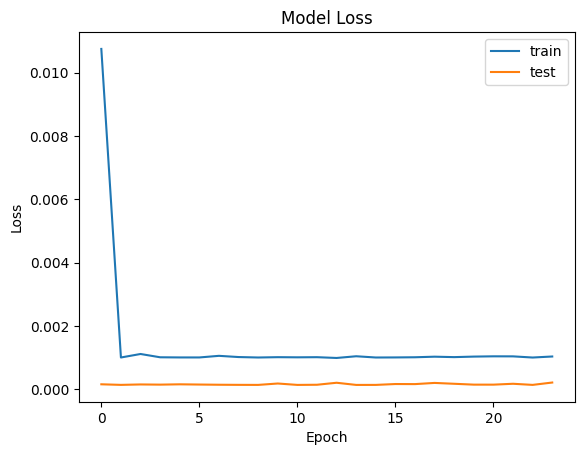

In [98]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Mean Absolute Error: 0.007571472502459971
Mean Squared Error: 0.00013681773243573515
R-squared: -0.04315466898700726


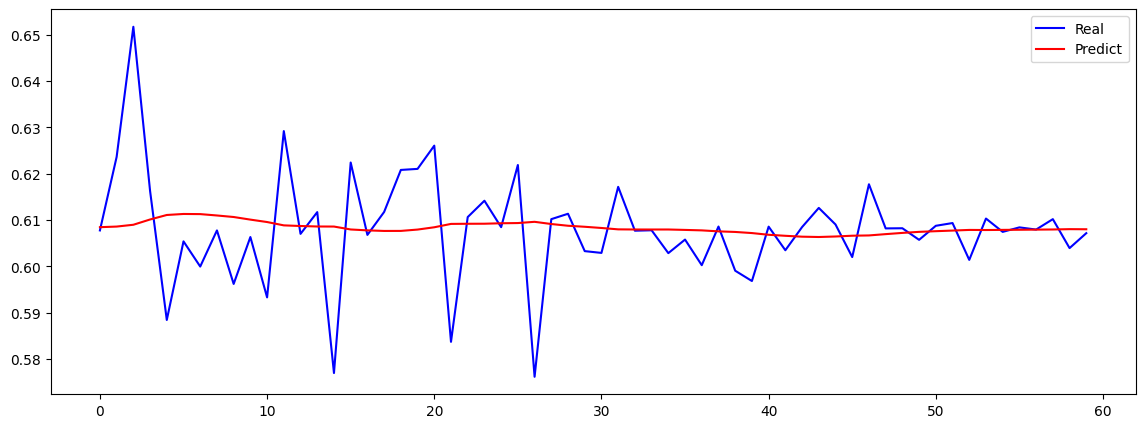

In [99]:
# Predictions
predictions = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(y_test, label="Real", color="blue")
plt.plot(predictions, label="Predict", color="red")
plt.legend()
plt.show()

In [100]:
np.unique(predictions, return_counts=True)

(array([0.6063489 , 0.6064181 , 0.6064581 , 0.60660833, 0.606626  ,
        0.60668534, 0.606828  , 0.60696805, 0.6071983 , 0.6072312 ,
        0.6074386 , 0.6074586 , 0.607565  , 0.60760194, 0.6076554 ,
        0.6076633 , 0.6077364 , 0.60777724, 0.6077793 , 0.607853  ,
        0.60787463, 0.6078777 , 0.60788476, 0.6079077 , 0.60793984,
        0.6079512 , 0.6079633 , 0.6079667 , 0.60796803, 0.6079694 ,
        0.6079709 , 0.6079971 , 0.60801876, 0.6080409 , 0.6082944 ,
        0.6084464 , 0.6084666 , 0.6085547 , 0.6085981 , 0.6086023 ,
        0.6086154 , 0.60872114, 0.60877454, 0.60885686, 0.60898817,
        0.6091472 , 0.60917217, 0.6092027 , 0.6092128 , 0.6093099 ,
        0.6093563 , 0.6095762 , 0.60962325, 0.61009794, 0.61012614,
        0.6106602 , 0.6109896 , 0.61109716, 0.6112855 , 0.6113156 ],
       dtype=float32),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1

In [101]:
print(X_test[0])

[0.61291046 0.60814824 0.59838026 0.61387396 0.61147981 0.60821146
 0.57102143 0.62703788 0.61268981 0.6062316  0.59798045 0.60499383
 0.60776737 0.60750932 0.60589431 0.6046286  0.62625113 0.59973189
 0.61238225 0.60776737 0.5996821  0.61565192 0.60297724 0.60979012
 0.60856964 0.60516371 0.60776737 0.62067896 0.61541328 0.60694206
 0.60662381 0.60776737 0.60735431 0.60776737 0.61387593 0.60399192
 0.6049068  0.61173038 0.61505713 0.60776737 0.59734809 0.6055406
 0.61132216 0.59076406 0.61663588 0.60776737 0.60665003 0.60776737
 0.61235101 0.60776737 0.59941547 0.61721427 0.60776737 0.60964179
 0.60614543 0.61068778 0.60776737 0.60662376 0.61708315]


In [102]:
def predict(
    day: datetime,
    data: pd.DataFrame,
    model,
    previous_days: int,
    last_day: datetime,
) -> List[float]:
    last_data = data.iloc[-previous_days + 1 :]["change"].values
    days = day - last_day
    days = days.days
    for i in range(days):
        pred = model.predict([last_data])[0]
        last_data = np.append(last_data[1:], pred)
        print(pred)
    return last_data[-1]

In [103]:
predict(datetime.datetime(2023, 12, 14), df, model, previous_days, df["date"].iloc[-1])

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32,), dtype=float32). Expected shape (None, 59, 1), but input has incompatible shape (32,)[0m

Arguments received by Sequential.call():
  • inputs=('tf.Tensor(shape=(32,), dtype=float32)',)
  • training=False
  • mask=('None',)

In [ ]:
df["date"].iloc[-1]

Timestamp('2023-12-13 00:00:00')